In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
# Utility Methods

def filter_columns(dataframe: pd.DataFrame, dtype, exclude_columns=None):
    """ Helper method to select DataFrame columns by dtype
    and select columns to drop. """
    if exclude_columns is None:
        exclude_columns = []
    return [
        col for col in dataframe.select_dtypes(include=[dtype]).columns
        if col not in exclude_columns
    ]

In [30]:
class Notebook:
    def __init__(self, csv):
        self.dataframe = pd.read_csv('transformed_failure_data.csv')
       
    # ------  CSV  F I L E S  ------ #  ^
    
        # failure_data
        # reformatted_data
        # pre_transform_data     -->     imputed_data
        # transformed_failure_data

    # --------- Utility Methods ---------- #

    def _create_subplots(self, num_plots, cols=3, subplot_size=(5, 5)):
        """Helper method to handle subplot creation."""
        rows = (num_plots // cols) + (num_plots % cols > 0)
        plt.figure(figsize=(subplot_size[0] * cols, subplot_size[1] * rows))
        return rows, cols

    # ----------------------- M E T H O D S ------------------------- #
        
    def plot_boxplots(self, columns=None, x_column=None, exclude_columns=None):
        """
        Generate boxplots for specified columns, optionally comparing against
        a categorical column (like failure states).

        Parameters:
            columns (list): List of columns to plot. If None, all numeric columns
                            will be used.
            x_column (str): Categorical column for x-axis (e.g., 'Machine failure').
                            If None, boxplots will be created without a categorical comparison.
            exclude_columns (list): List of columns to exclude from the plots.
        """
        # If columns are not provided, default to all numeric columns
        if columns is None:
            columns = filter_columns(self.dataframe, np.number, exclude_columns)

        num_cols = len(columns)

        # Create subplots based on number of columns
        rows, cols = self._create_subplots(num_cols, cols=3, subplot_size=(5, 6))

        # Plot each column
        for i, col in enumerate(columns, 1):
            plt.subplot(rows, cols, i)

            # If x_column is provided, use it for comparison, else plot simple boxplot
            if x_column:
                sns.boxplot(x=x_column, y=self.dataframe[col], data=self.dataframe)
                plt.xlabel(x_column)
            else:
                sns.boxplot(x=self.dataframe[col])
                plt.xlabel('')

            plt.title(f'Boxplot of {col}')

        plt.suptitle('Boxplots for Selected Columns')
        plt.tight_layout()
        plt.show()

In [31]:
nb = Notebook('pre_transform_data.csv')

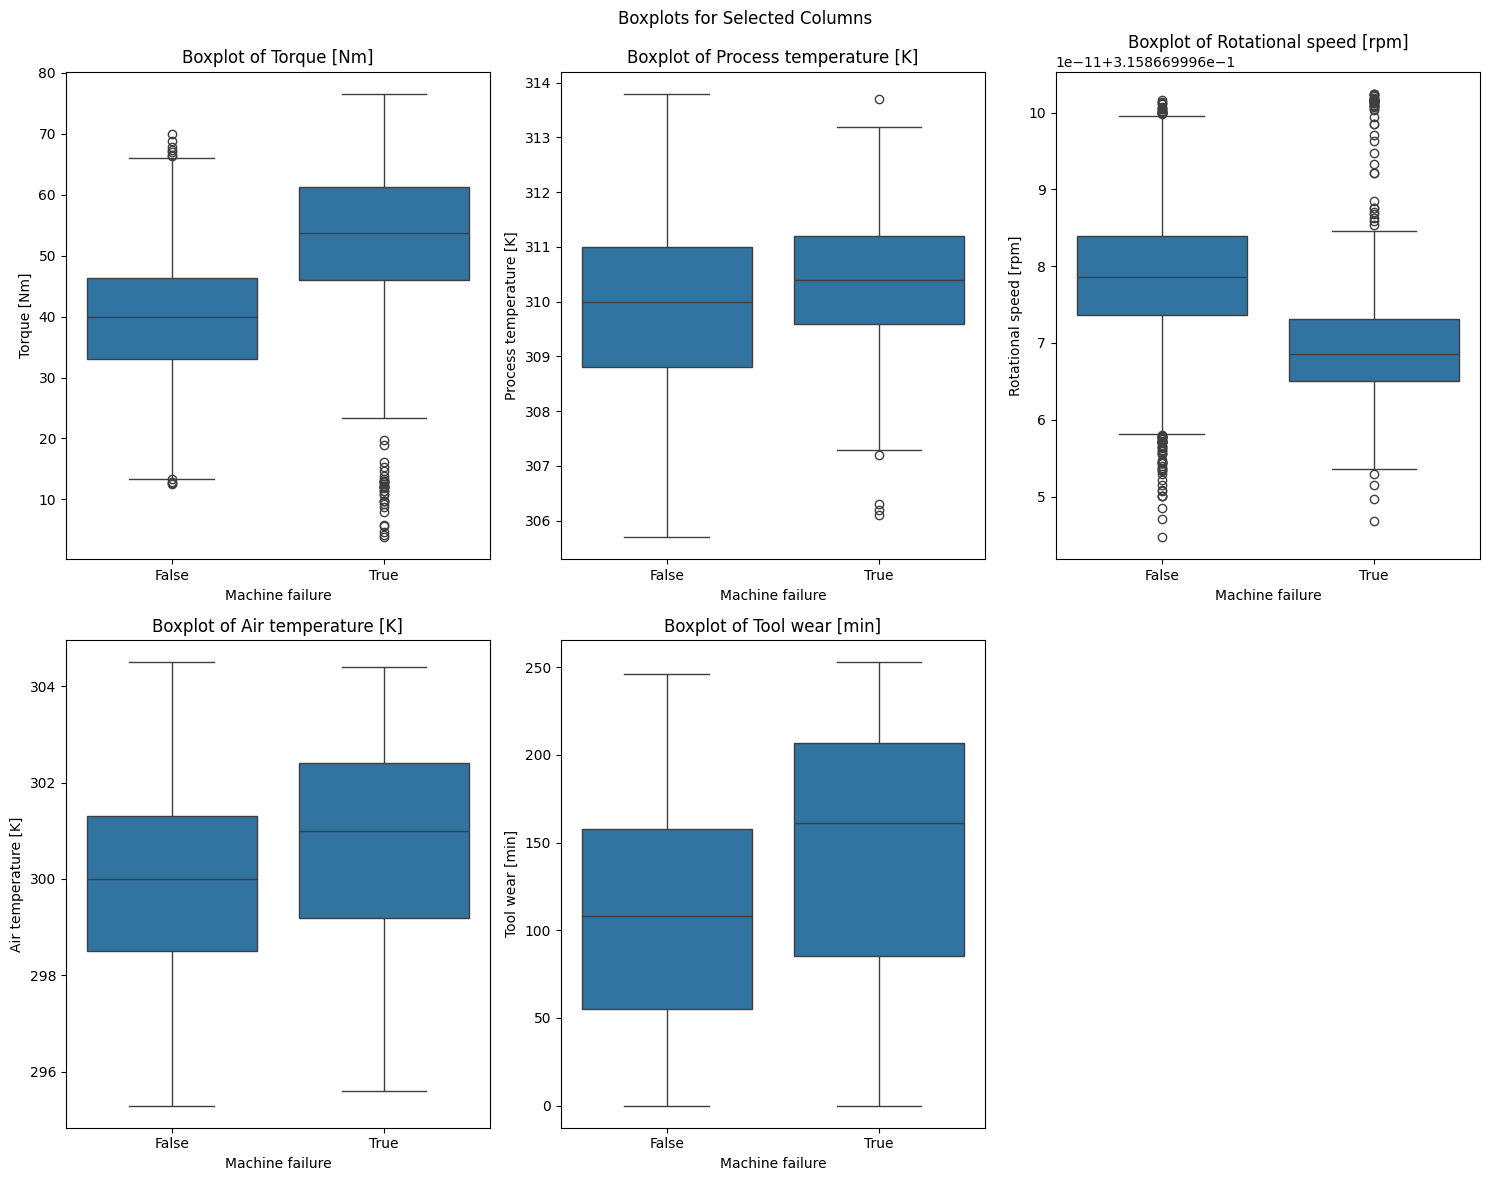

In [33]:
fail_type = ['Machine failure']
columns_to_plot = ['Torque [Nm]', 'Process temperature [K]',
                   'Rotational speed [rpm]', 'Air temperature [K]',
                   'Tool wear [min]']
for fail_type in fail_type:
    nb.plot_boxplots(columns=columns_to_plot, x_column=fail_type)

In [ ]:

# -------------   F I N I S H E D    M E T H O D S   -------------- #

    def failure_rate_analysis(self, selected_column, target_column):
        """
        Line plot:
        Divide the selected column values into bins and calculate the failure rate
        within each bin. Visualise the failure rate against the selected column
        to identify a recommended maximum value.

        Parameters:
            selected_column (str): The column to divide into bins (e.g., 'Torque [Nm]').
            target_column (str): The target column indicating failures (e.g., 'HDF').
        """
    
        # Creating bins with a width of 10 units to group similar values together
        self.dataframe['Selected Bin'] = pd.cut(
            self.dataframe[selected_column],
            # Create bins of from 0 to max value + 10, end number = bin width
            bins=range(0, int(self.dataframe[selected_column].max()) + 2, 2),
            right=False  # Ensures the bins are left-closed, right-open
        )
    
        # Calculating the total count and failure count for each bin
        bin_failure_counts = self.dataframe.groupby('Selected Bin')[target_column].sum()
        bin_total_counts = self.dataframe.groupby('Selected Bin').size()
        failure_rate = (bin_failure_counts / bin_total_counts) * 100  # Calculate failure rate in percentage
    
        # Plotting failure rate for each bin to identify trends
        plt.figure(figsize=(10, 6))
        plt.plot(
            failure_rate.index.astype(str),  # Convert bin index to string for better x-axis labels
            failure_rate.values,  # Failure rate values
            marker='o',  # Use circle markers for data points
            linestyle='-',  # Connect data points with lines
            color='red'  # Set line color to red
        )
        plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
        plt.title(f'{target_column} Failure Rate vs {selected_column} Bins')  # Set plot title
        plt.xlabel(f'{selected_column} Bins')  # Set x-axis label
        plt.ylabel(f'{target_column} Failure Rate (%)')  # Set y-axis label
        plt.tight_layout()  # Adjust layout to prevent overlap
        plt.show()
    
        # Removing the 'Selected Bin' column after analysis to avoid affecting other calculations
        self.dataframe.drop(columns=['Selected Bin'], inplace=True)

